# Assignment 2 - AutoML Assignment to create predictive models and interpret them

**The MIT License**

Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Abstract

This notebook aims to create the pedictive models of Housing price of Beijing from 2011 to 2017, and interpret them. The steps include using pip installations and importing libraries. Proceeding further, a minimum memory size and a run time is set and 50% of availible resources are being used for the analysis and prediction after which H2O server starts on a random port. The data is then imported and studied. The Columns like url, id, Lng, Lat, totalPrice as they are irrelavant for predicting housing prices hence those columns are dropped. The Model is then trained Using H2O's AutoML. GBM Model is predicted by the AutoML. After which, RSME comparison and understanding the leader board is done. Plotting of Variable importance plot and Partial Dependence Plots is depicted. 




# Installing H2O.ai Automl for Python to run this notebook

Use pip install

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip uninstall -y h2o

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Found existing installation: h2o 3.38.0.2
Uninstalling h2o-3.38.0.2:
  Successfully uninstalled h2o-3.38.0.2
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
  Using cached h2o-3.38.0.2-py2.py3-none-any.whl


In [2]:
# Import libraries

import h2o
import pandas as pd
import logging
import csv
import optparse
import time
import json
import random, os, sys
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from h2o.automl import H2OAutoML
from datetime import datetime
from distutils.util import strtobool
import statsmodels.formula.api as smf


In [3]:
# Use 50% of availible resources

pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

0


Start the H2O server on a random port

In [4]:
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

try:
  # Start h2o
  h2o.init(strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no) 
except Exception as e:
  logging.critical(e)
  h2o.download_all_logs(dirname=".", filename="logfile.txt")        
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:47139 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "19" 2022-09-20; Java(TM) SE Runtime Environment (build 19+36-2238); Java HotSpot(TM) 64-Bit Server VM (build 19+36-2238, mixed mode, sharing)
  Starting server from /Users/vaibhav/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/f0/1mhbwvz904v6jv5d8zv096y00000gn/T/tmp_7057l0w
  JVM stdout: /var/folders/f0/1mhbwvz904v6jv5d8zv096y00000gn/T/tmp_7057l0w/h2o_vaibhav_started_from_python.out
  JVM stderr: /var/folders/f0/1mhbwvz904v6jv5d8zv096y00000gn/T/tmp_7057l0w/h2o_vaibhav_started_from_python.err
  Server is running at http://127.0.0.1:47139
Connecting to H2O server at http://127.0.0.1:47139 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_vaibhav_6up7s2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


# Import, Understand and Manage Data 

In [6]:
# Importing required libraries
import pandas as pd
import numpy as np

df = h2o.import_file(path = "new.csv")
# Dataset is now stored in a Pandas Dataframe

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# show initial data
df.head() 

url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
https://bj.lianjia.com/chengjiao/101084782030.html,1.01085e+11,116.475,40.0195,1.11103e+12,2016-08-09 00:00:00,1464,106,415,31680,131,2,1,1,1,<0xB8DF> 26,1,2005,3,6,0.217,1,0,1,7,56021
https://bj.lianjia.com/chengjiao/101086012217.html,1.01086e+11,116.454,39.8815,1.11103e+12,2016-07-28 00:00:00,903,126,575,43436,132.38,2,2,1,2,<0xB8DF> 22,1,2004,4,6,0.667,1,1,0,7,71539
https://bj.lianjia.com/chengjiao/101086041636.html,1.01086e+11,116.562,39.8771,1.11104e+12,2016-12-11 00:00:00,1271,48,1030,52021,198,3,2,1,3,<0xD6D0> 4,4,2005,3,6,0.5,1,0,0,7,48160
https://bj.lianjia.com/chengjiao/101086406841.html,1.01086e+11,116.438,40.0761,1.11104e+12,2016-09-30 00:00:00,965,138,297.5,22202,134,3,1,1,1,<0xB5D7> 21,1,2008,1,6,0.273,1,0,0,6,51238
https://bj.lianjia.com/chengjiao/101086920653.html,1.01087e+11,116.428,39.8862,1.11103e+12,2016-08-28 00:00:00,927,286,392,48396,81,2,1,1,1,<0xD6D0> 6,4,1960,2,2,0.333,0,1,1,1,62588
https://bj.lianjia.com/chengjiao/101087277815.html,1.01087e+11,116.466,39.9914,1.11103e+12,2016-07-22 00:00:00,861,57,275.6,52000,53,1,0,1,1,<0xD6D0> 8,4,2005,3,6,0.333,1,1,0,7,67738
https://bj.lianjia.com/chengjiao/101087292623.html,1.01087e+11,116.483,39.892,1.11103e+12,2016-07-14 00:00:00,851,167,275,37672,73,2,1,1,1,<0xB8DF> 6,4,1997,4,2,0.5,0,0,0,7,50112
https://bj.lianjia.com/chengjiao/101087303800.html,1.01087e+11,116.454,39.8815,1.11103e+12,2016-09-07 00:00:00,904,138,800,49521,161.55,3,2,1,2,<0xB8DF> 22,1,2004,4,6,0.667,1,1,0,7,71539
https://bj.lianjia.com/chengjiao/101087463212.html,1.01087e+11,116.556,40.1621,1.11103e+12,2016-09-04 00:00:00,873,218,134,27917,48,1,0,1,1,<0xB8DF> 10,3,2009,1,2,0.333,0,0,0,13,44235
https://bj.lianjia.com/chengjiao/101087508625.html,1.01088e+11,116.453,39.8984,1.11103e+12,2016-09-05 00:00:00,865,134,380,55883,68,1,0,0,0,<0xD6D0> 23,1,2009,4,6,0.308,1,1,1,1,78590


# Correlation matrix
to show the relation between the columns data

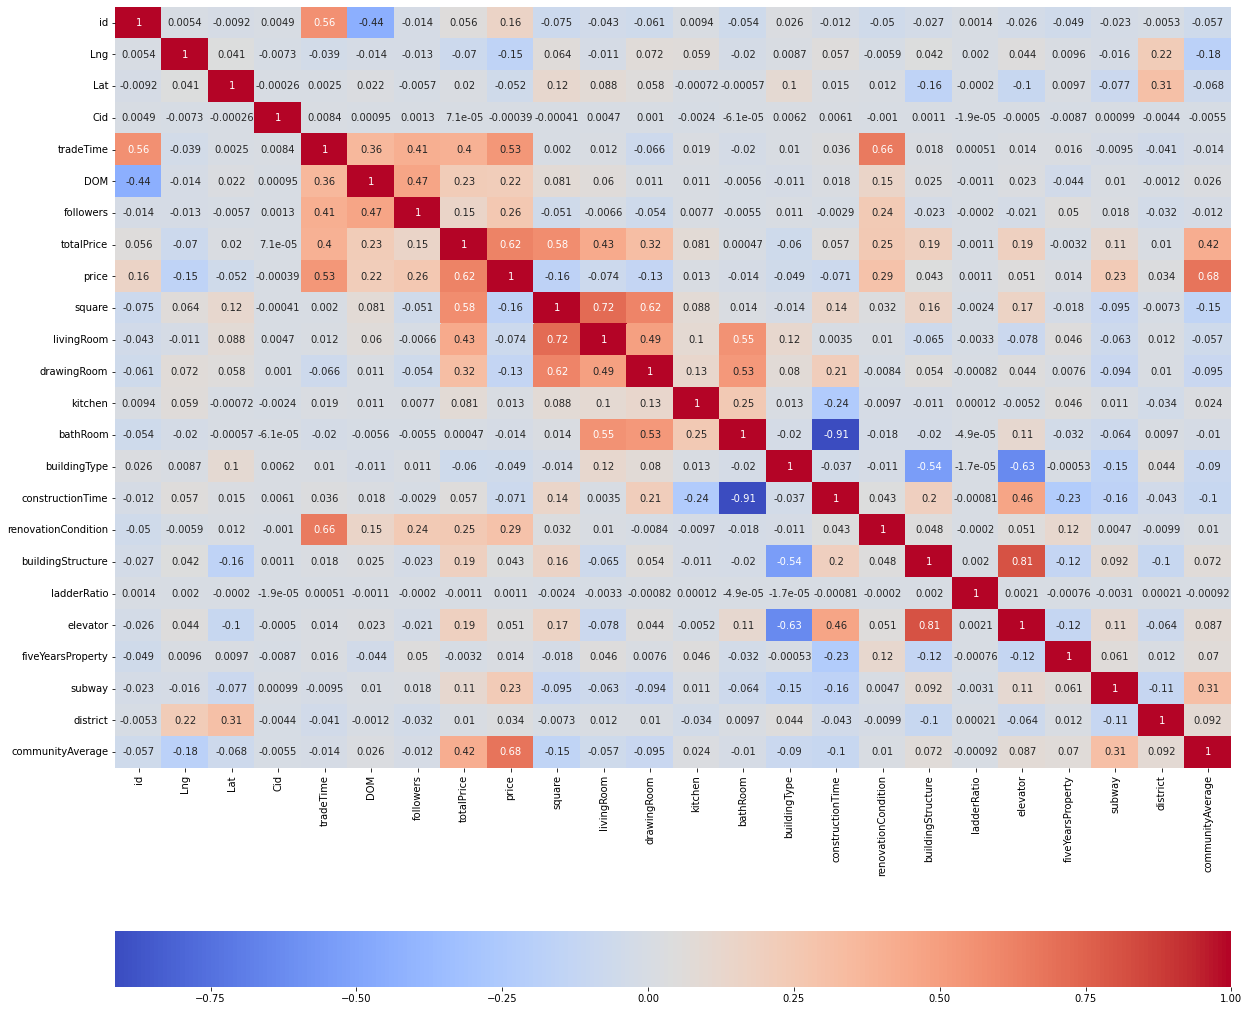

In [ ]:
# Import plotting libraries
import seaborn as sn
import matplotlib.pyplot as plt

df_copy = df.as_data_frame()
corr_matrix = df_copy.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sn.heatmap(corr_matrix, annot=True, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'} , fmt='.2g')
plt.show()

Dropping Columns: 
1. url 
2. id
3. Lng
4. Lat
5. totalPrice 

They are irrelavant for predicting "prices" hence dropping those columns.

In [10]:
df = df.drop(['url', 'id', 'Lng',	'Lat', 'totalPrice' ], 1)

In [11]:
# Showing the datatype of columns we have.
df.types

{'Cid': 'int',
 'tradeTime': 'time',
 'DOM': 'int',
 'followers': 'int',
 'price': 'int',
 'square': 'real',
 'livingRoom': 'int',
 'drawingRoom': 'int',
 'kitchen': 'int',
 'bathRoom': 'int',
 'floor': 'enum',
 'buildingType': 'real',
 'constructionTime': 'int',
 'renovationCondition': 'int',
 'buildingStructure': 'int',
 'ladderRatio': 'real',
 'elevator': 'int',
 'fiveYearsProperty': 'int',
 'subway': 'int',
 'district': 'int',
 'communityAverage': 'int'}

In [12]:
# Number of rows and colums we have
df.describe()

Rows:318851
Cols:21

,Cid,tradeTime,DOM,followers,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
type,int,time,int,int,int,real,int,int,int,int,enum,real,int,int,int,real,int,int,int,int,int
mins,1111027373683.0,1022889600000.0,1.0,0.0,1.0,6.9,0.0,0.0,0.0,0.0,,0.048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10847.0
mean,1129113334722.6533,1429304082521.3074,28.822339221999947,16.7315078202672,43530.43637937471,83.24059670504381,2.010369520009791,1.1719502288132142,0.9945993583209709,1.376444649348122,,3.0097898021020715,1999.002516957751,2.6063302294802346,4.451025714205087,63.16486041442529,0.5770546924744134,0.6456014227508399,0.6011122298231912,6.763563545355041,63682.44630450887
maxs,1114619720585020.0,1517097600000.0,1677.0,1143.0,156250.0,1745.5,9.0,5.0,4.0,2011.0,,4.0,2016.0,4.0,6.0,10009400.0,1.0,1.0,1.0,13.0,183109.0
sigma,2363446816043.3027,51679982447.77147,50.23734256593315,34.209184723383274,21709.024203593806,37.23466088010082,0.7768224538956191,0.5222874790385732,0.10960891166970874,19.41892502826843,,1.2698573107952484,22.44379264740486,1.311738516830613,1.901753432753746,25068.50608342917,0.49402767117932755,0.4783314158033756,0.4896703677568865,2.812616086044164,22329.215447185845
zeros,0,0,0,83487,0,0,28,19686,2680,915,,0,16,26,28,32,134843,112989,127173,0,0
missing,0,0,157977,0,0,0,32,32,0,2,0,2021,19283,0,0,0,32,32,32,0,463
0,1111027376244.0,2016-08-09 00:00:00,1464.0,106.0,31680.0,131.0,2.0,1.0,1.0,1.0,<0xB8DF> 26,1.0,2005.0,3.0,6.0,0.217,1.0,0.0,1.0,7.0,56021.0
1,1111027381879.0,2016-07-28 00:00:00,903.0,126.0,43436.0,132.38,2.0,2.0,1.0,2.0,<0xB8DF> 22,1.0,2004.0,4.0,6.0,0.667,1.0,1.0,0.0,7.0,71539.0
2,1111040862969.0,2016-12-11 00:00:00,1271.0,48.0,52021.0,198.0,3.0,2.0,1.0,3.0,<0xD6D0> 4,4.0,2005.0,3.0,6.0,0.5,1.0,0.0,0.0,7.0,48160.0


In [13]:
# Showing the data shape before spliting into training and test.
df.shape

(318851, 21)

In [14]:
# Splitting the test and training dataset in ration 4:1

pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

print(df_train.shape)
print(df_test.shape)

(254927, 21)
(63924, 21)


In [15]:
df_train.head()

Cid,tradeTime,DOM,followers,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
1.11103e+12,2016-08-09 00:00:00,1464,106,31680,131,2,1,1,1,<0xB8DF> 26,1,2005,3,6,0.217,1,0,1,7,56021
1.11103e+12,2016-07-28 00:00:00,903,126,43436,132.38,2,2,1,2,<0xB8DF> 22,1,2004,4,6,0.667,1,1,0,7,71539
1.11104e+12,2016-12-11 00:00:00,1271,48,52021,198,3,2,1,3,<0xD6D0> 4,4,2005,3,6,0.5,1,0,0,7,48160
1.11104e+12,2016-09-30 00:00:00,965,138,22202,134,3,1,1,1,<0xB5D7> 21,1,2008,1,6,0.273,1,0,0,6,51238
1.11103e+12,2016-07-22 00:00:00,861,57,52000,53,1,0,1,1,<0xD6D0> 8,4,2005,3,6,0.333,1,1,0,7,67738
1.11103e+12,2016-09-07 00:00:00,904,138,49521,161.55,3,2,1,2,<0xB8DF> 22,1,2004,4,6,0.667,1,1,0,7,71539
1.11103e+12,2016-09-04 00:00:00,873,218,27917,48,1,0,1,1,<0xB8DF> 10,3,2009,1,2,0.333,0,0,0,13,44235
1.11103e+12,2016-09-05 00:00:00,865,134,55883,68,1,0,0,0,<0xD6D0> 23,1,2009,4,6,0.308,1,1,1,1,78590
1.11103e+12,2016-08-24 00:00:00,827,95,31579,266,4,2,1,3,<0xD6D0> 4,nan,2006,3,6,0.2,0,0,0,7,57260
1.11103e+12,2016-08-03 00:00:00,773,74,26250,48,1,1,1,1,<0xB5D7> 11,3,2009,3,2,0.333,0,1,0,13,44235


# Train Models Using H2O's AutoML

Set the features and target

In [16]:
# Set the features and target
X = df.columns
print(X)

['Cid', 'tradeTime', 'DOM', 'followers', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'constructionTime', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage']


Set target and predictor variables

In [17]:
# Set target and predictor variables
y ='price'

X.remove(y) 

print(X)

['Cid', 'tradeTime', 'DOM', 'followers', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'constructionTime', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage']


Set up AutoML

H20 AutoML will automatically perform regression or classification depedending on the target data type.

In [18]:
# Set up AutoML and run time in seconds
run_time = 222
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [19]:
aml.train(x=X,y=y,training_frame=df_train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_2_AutoML_1_20221108_44646

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 9490894.662398916
RMSE: 3080.7295665797924
MAE: 2095.5038910902413
RMSLE: 0.23397486392915282
Mean Residual Deviance: 9490894.662398916
R^2: 0.9797650141996416
Null degrees of freedom: 9950
Residual degrees of freedom: 9948
Null deviance: 4667382455979.45
Residual deviance: 94443892785.53162
AIC: 188118.922762941

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 23581635.860387743
RMSE: 4856.092653604103
MAE: 3059.126297833379
RMSLE: 0.2924421461494471
Mean Residual Deviance: 23581635.860387743
R^2: 0.9510709053852554
Null degrees of freedom: 25429
Residual degrees of freedom: 25427
Null deviance: 12258059640833.867
Residual deviance: 599680999929.6603
AIC: 503874.3553332279

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [20]:
print(aml.leaderboard)

model_id                                                    rmse          mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_2_AutoML_1_20221108_44646   4856.09  2.35816e+07   3059.13  0.292442               2.35816e+07
StackedEnsemble_BestOfFamily_1_AutoML_1_20221108_44646   4856.09  2.35816e+07   3059.13  0.292442               2.35816e+07
GBM_1_AutoML_1_20221108_44646                            5057.32  2.55764e+07   3203.42  0.294713               2.55764e+07
XGBoost_1_AutoML_1_20221108_44646                        5095.98  2.59691e+07   3264.07  0.294758               2.59691e+07
XGBoost_2_AutoML_1_20221108_44646                        5777.6   3.33807e+07   3847.58  0.300984               3.33807e+07
GBM_3_AutoML_1_20221108_44646                            6961.92  4.84684e+07   4845.77  0.325912               4.84684e+07
GBM_2_AutoML_1_20221108_44646                            8026.41  6.44232e+07   5720.53  0.342619               6.44232e+07
GBM_4_Au

# RSME comparison and understanding the leader board

The best models after running for a little under four minutes is around 0.005 about half of that of the 0.010 RSME that we got our simple MLP in notebook one and a quarter of the 0.017 RSME that we got with a simple MLP with the same independent variables.

When we run for a short time, under 10 minutes, out leaderboard with be biased towards trre-based methods as the deep learners take much more time to converge. It is rare to see deep learners in the top 500 models when we run for less than 5 minutes.

We should still plot the results but before we do that let's discuss a big advantage of these models, model interpretability.

In [21]:
# Get the best model index

model_index = 0
glm_index = 0
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df['model_id']:
  models_dict[m] = model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index = model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m] = glm_index
    break  
  glm_index = glm_index+1  

models_dict

{'StackedEnsemble_BestOfFamily_2_AutoML_1_20221108_44646': 0,
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20221108_44646': 1,
 'GBM_1_AutoML_1_20221108_44646': 2,
 'GLM_1_AutoML_1_20221108_44646': 9}

Examine the Best Model

In [22]:
# Get best model ALGO
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])
best_model.algo

'gbm'

# Variable importance plot

Variable importance plots in tree-based methods provides a list of the most significant variables in descending order by a measure of the information in each variable. Remember that tree calculates the information content of each variable. A variable importance plot is just a bar chart of each variables information content in decreasing order.

It can show actual information estimates or standardized plots like the one below. In a standardized plot the most important variable is always given a value of 1.0. The other variables scores represent their percentage of information relative to the most important variable.

Notice that some varibales have almost no information content. Knowing this allows for feature selection by removing unimportant variables. This makes a model more effecient to run and helps prevent overfitting as the unimportant variables can fit noise and, as we saw in notebook one, make strange predictions.



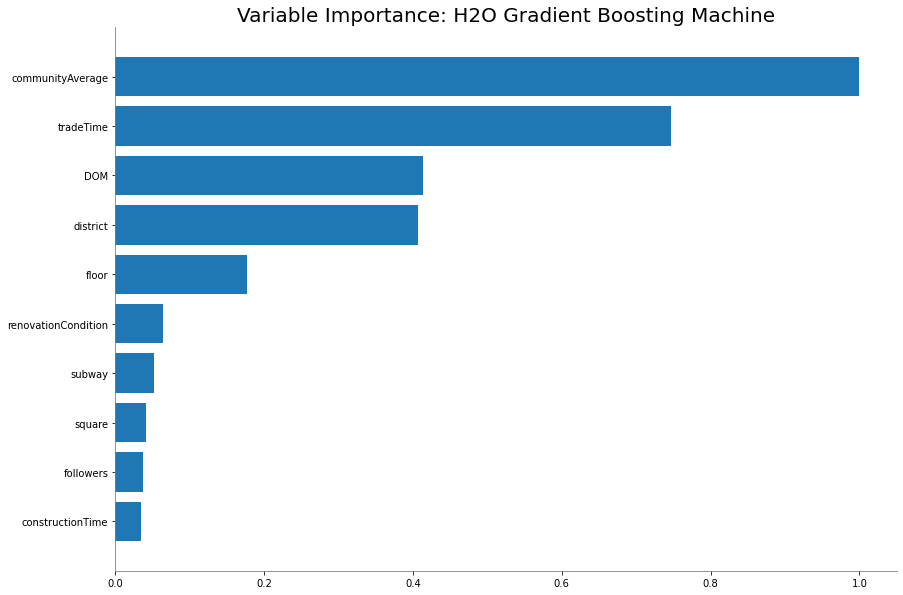

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the Variable importance
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1450 missing from current font.
  font.set_text(s, 0, flags=flags)


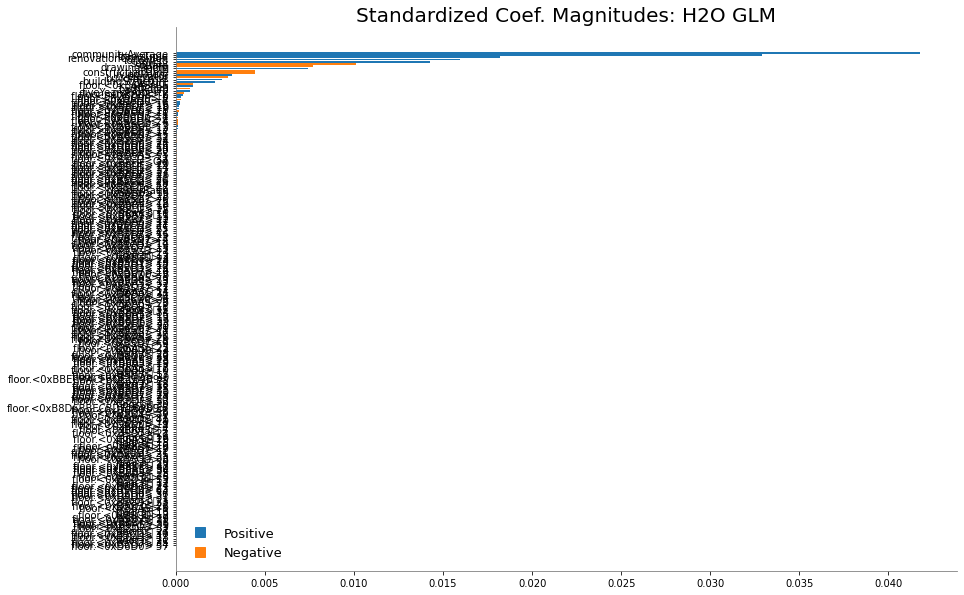

In [24]:
# Plot standard Coeficient chart of GML model
if glm_index is not 0:
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id']) 
  glm_model.std_coef_plot()

RMSE of the best model

In [25]:
# RMSE of the best model we got
best_model.rmse(train = True)

3452.2260977119877

# Run the prediction



In [26]:
# Running the predition
predictions = best_model.predict(df_test)
predictions.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
45675.9
34177.3
85705.1
51204
42934.8
52110.3
24562.5
59784.2
30674.6
61661.1


In [27]:
# Original values
df_test[y].head()

price
48396
37672
91710
52668
50672
58888
22078
67470
34992
67678


In [28]:
# Check the performace of model
perf = aml.leader.model_performance(df_test)
perf

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 23535455.01120925
RMSE: 4851.335384325562
MAE: 3034.245592265744
RMSLE: 0.2787242262021311
Mean Residual Deviance: 23535455.01120925
R^2: 0.9501609786999091
Null degrees of freedom: 63923
Residual degrees of freedom: 63921
Null deviance: 30187269492774.39
Residual deviance: 1504480426136.54
AIC: 1266463.616407107

# Partial Dependence Plots

Partial dependence plots (PDP) show the dependence between the target response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected target response as a function of the feature.

The partial dependence plot gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. This helps one answer the question of how changing a variables values would change the outcome.

The partial dependence plots show only impact of single variable if others are kept constant. But in many cases, there is interaction between variables. Never-the-less, they are very useful in estimating whether, for example, doubling some predictor varible will double a response or whether that predictor varible is already saturated.



In [1]:
# Partial plot of column "square", "buildingType", "communityAverage", "tradeTime"
best_model.partial_plot(df, cols=['buildingType', 'communityAverage', 'tradeTime', 'square'])


NameError: name 'best_model' is not defined

In [29]:
results = smf.ols(formula='price ~ communityAverage + tradeTime + district + DOM + floor + renovationCondition + subway + square + constructionTime + followers', data=df.as_data_frame()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     9422.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):               0.00
Time:                        04:54:44   Log-Likelihood:            -1.6400e+06
No. Observations:              153260   AIC:                         3.280e+06
Df Residuals:                  153193   BIC:                         3.281e+06
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -3.939e+05   8357.569    -47.126      0.000    -4.1e+05   -3.77e+05
floor[T.<0xB5CD> 11]          -1358.8981    666.383     -2.039      0.041   -2664.996     -52.800
floor[T.<0xB5CD> 12]          -1148.4191    644.641     -1.781      0.075   -2411.903     115.065
floor[T.<0xB5CD> 13]          -1763.5604    759.503     -2.322      0.020   -3252.171    -274.950
floor[T.<0xB5CD> 14]          -2367.5078    651.703     -3.633      0.000   -3644.831   -1090.184
floor[T.<0xB5CD> 15]          -2817.8379    652.241     -4.320      0.000   -4096.217   -1539.459
floor[T.<0xB5CD> 16]          -1975.0100    599.807     -3.293      0.001   -3150.619    -799.401
floor[T.<0xB5CD> 17]          -1526.8437    706.816     -2.160      0.031   -2912.189    -141.499
floor[T.<0xB5CD> 18]          -2305.4230    584.415     -3.945      0.000   -3450.864   -1159.982
floor[T.<0xB5CD> 19]          -3922.6928    711.961     -5.510      0.000   -5318.121   -2527.265
floor[T.<0xB5CD> 2]           -1.214e+04   1.02e+04     -1.189      0.235   -3.22e+04    7874.390
floor[T.<0xB5CD> 20]          -2813.5666    635.501     -4.427      0.000   -4059.136   -1567.997
floor[T.<0xB5CD> 21]          -3182.6509    628.144     -5.067      0.000   -4413.800   -1951.502
floor[T.<0xB5CD> 22]          -2319.9875    636.733     -3.644      0.000   -3567.972   -1072.003
floor[T.<0xB5CD> 23]          -3003.5441    767.598     -3.913      0.000   -4508.021   -1499.068
floor[T.<0xB5CD> 24]          -3237.2374    606.382     -5.339      0.000   -4425.734   -2048.741
floor[T.<0xB5CD> 25]          -2005.7833    667.829     -3.003      0.003   -3314.714    -696.852
floor[T.<0xB5CD> 26]           -688.0313    663.445     -1.037      0.300   -1988.369     612.306
floor[T.<0xB5CD> 27]          -2378.7725    689.272     -3.451      0.001   -3729.731   -1027.814
floor[T.<0xB5CD> 28]          -5197.8505    643.893     -8.073      0.000   -6459.867   -3935.833
floor[T.<0xB5CD> 29]          -1429.4064    874.465     -1.635      0.102   -3143.339     284.526
floor[T.<0xB5CD> 3]           -5436.2778   1260.578     -4.313      0.000   -7906.985   -2965.571
floor[T.<0xB5CD> 30]          -3083.1473    794.127     -3.882      0.000   -4639.619   -1526.675
floor[T.<0xB5CD> 31]          -3823.1906   1308.626     -2.922      0.003   -6388.071   -1258.310
floor[T.<0xB5CD> 32]          -2055.1927    817.938     -2.513      0.012   -3658.334    -452.052
floor[T.<0xB5CD> 33]          -5324.5973   1180.142     -4.512      0.000   -7637.652   -3011.543
floor[T.<0xB5CD> 34]           -252.7989   1301.402     -0.194      0.846   -2803.519    2297.922
floor[T.<0xB5CD> 35]           4156.9961   1.05e+04      0.394      0.694   -1.65e+04    2.48e+04
floor[T.<0xB5CD> 36]          -7688.7931   76

Question 1. Is the relationship significant?

Answer: As shown in the variable importance plot, we can see that Community Average, Trade time, DOM, district and Floor plan are significantly related with the price column as compared to the renovation condition, subway etc.

Also, the p-value is 0 for all the columns except for Square Feet. This depicts that we can ignore the null hypothesis.

Question 2. Are any model assumptions violated?

Answer - As the multicollinearity exist in the matrix, we can say it violated the assumption.



Question 3. Is there any multicollinearity in the model?

Answer - As from the multicollinearity matrix, it can be seen that only the Squarefeet and Community Average are highly correlated which can be seen from the pairplot as well.

Question 4. In the multivariate models, are predictor variables independent of all other predictor variables?

Answer -  Accordijng to correlation matrix, the predictor variables are independent of each other. Only,  Community Average and Square depicts that they are dependent.

Question 5. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

Answer- 
1. communityAverage
2. tradeTime
3. District
4. DOM
5. floor
6. rennovationCondition
7. Subway
8. Square

Question 6. Does the model make sense?

Answer- As we see from the above preditions and models, GBM is the best predicted model for this case and the metrics MSE, RMSE as well.

Question 7. Does regularization help?

Answer- We found that once we tune in the different values, the  MSE and RMSE does not improve, apart from that, the metrics value declines. Therefore, we can say that the regularization doesn not help that much.

Question 8. Which independent variables are significant?

Answer- As from the variable importance graph, we can see that Community Average, Trade time, DOM, district and Floor plan are significant.

Question 9. Which hyperparameters are important?

Answer- Hyperparameters are used to regulate the network structure. They genrally control the learning process and control the values of model parameters. The n_estimators and max_depth are used as hyperparameters here.

# Conclusion

The AutoML is used to predict the best fitting model and has been conlcuded that Community Average, Trade time, DOM, district and Floor play a major role in determinignthe housing price. The RSME value is calculated as 3482.2191707476786 and a plot for partial Dependence Plot of model GBM_1_AutoML_1_20221108_15532 on column 'square' is depicted.




# Citations

Reference Links: 
https://github.com/nikbearbrown/AI_Research_Group/blob/main/Kaggle_Datasets/AutoML/VAI_Churn_H2O_automl.ipynb
https://www.statology.org/z-score-python/
